# GetOrganelles Recovery

In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from tqdm import tqdm
from datetime import date

In [109]:
latest_db='C:/Data/PAFTOL/PAFTOL_DB/2021-06-15_paftol_export.csv'

## List of Samples

In [110]:
# PAFTOL
working_dir='C:/Data/PAFTOL/GetOrganelles/PAFTOL/'
project=working_dir.split('/')[-2]; print(project)
sample_file=latest_db
Org_df = pd.read_csv(sample_file)
print(Org_df.shape)
# List those from paftol, completed, and with fastq files
Org_df = Org_df[(Org_df.DataSource=='PAFTOL') & (Org_df.Library_Status=='Completed') & (Org_df.R1FastqFile.isna()==False)]
print(Org_df.shape)
Org_df['sci_name']=Org_df.Genus + ' ' + Org_df.Species
Org_df['Sample_Name']='PAFTOL_' + Org_df.idSequencing.astype(int).astype('str').str.zfill(6)
Org_df=Org_df[['idPaftol','idSequencing','Sample_Name','Project','Order','Family','Genus','sci_name','SumContigLength']]
Org_df=Org_df.rename(columns={'Order':'order','Family':'family','Genus':'genus'})
Org_df[:2]

PAFTOL
(15052, 73)
(7540, 73)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (43,55,66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,idPaftol,idSequencing,Sample_Name,Project,order,family,genus,sci_name,SumContigLength
9,2.0,961.0,PAFTOL_000961,Pilot,Ranunculales,Circaeasteraceae,Circaeaster,Circaeaster agrestis,138795.0
11,4.0,2571.0,PAFTOL_002571,Connaraceae,Oxalidales,Connaraceae,Rourea,Rourea minor,NaN


In [111]:
# # IdPaftol
# working_dir='C:/Data/PAFTOL/GetOrganelles/idPaftol/'
# project=working_dir.split('/')[-2]; print(project)
# sample_file='C:/Data/PAFTOL/PAFTOL_DB/2021-04-12_paftol_export.csv'
# Org_df = pd.read_csv(sample_file)
# Org_df = Org_df[(Org_df.DataSource=='PAFTOL') & (Org_df.Library_Status=='Completed') & (Org_df.R1FastqFile.isna()==False)]
# Org_df['sci_name']=Org_df.Genus + ' ' + Org_df.Species
# Org_df['Sample_Name']='PAFTOL_Sample_' + Org_df.idPaftol.astype('str').str.zfill(6)
# print(Org_df.shape)
# Org_df=Org_df.groupby('idPaftol').agg({'Sample_Name':['first'],'idSequencing':['count'],'Order':['first'],
#                                        'Family':['first'],'Genus':['first'], 'sci_name':['first'],'SumContigLength':['mean']})\
#         .reset_index().droplevel(1, axis=1) 
# Org_df=Org_df[Org_df.idSequencing>1]
# Org_df=Org_df.rename(columns={'Order':'order','Family':'family','Genus':'genus','idSequencing':'Nruns'})
# print(Org_df.shape)
# Org_df

In [112]:
# # SRA
# working_dir='C:/Data/PAFTOL/GetOrganelles/SRA/'
# project=working_dir.split('/')[-2]; print(project)

# sra_db=pd.read_csv(latest_db).rename(columns={'Order':'order','Family':'family','Genus':'genus','ExternalSequenceID':'AccessionID'})
# sra_db['sci_name']=sra_db.genus + ' ' + sra_db.Species
# sra_db=sra_db[sra_db.DataSource=='SRA'][['AccessionID','order','family','genus','sci_name']]

# Org_df = pd.merge(left=sra_db,
#                 right=pd.read_csv('C:/Data/PAFTOL/Public_Data/SRA/SRA_recovery_stats_tmp.csv')\
#                 .rename(columns={'accessionId':'AccessionID'}),how='left',on='AccessionID')        
# print(Org_df.shape)
# print(Org_df.isna().sum().to_dict())
# Org_df=Org_df[Org_df.SumContigLength.notnull()]
# print(Org_df.shape)
# Org_df['Sample_Name']=Org_df.AccessionID.astype('str')
# Org_df=Org_df[['Sample_Name','idSequencing','order','family','genus','sci_name','SumContigLength']]
# Org_df[:2]

## 1. Check logs

In [113]:
os.chdir(working_dir)
print(os.getcwd())
orgs=['pt','nr']

C:\Data\PAFTOL\GetOrganelles\PAFTOL


In [114]:
# Check logs
logs_df = pd.DataFrame(os.listdir('logs/'),columns=['file'])
logs_df['Sample_Name'] = logs_df.file.str.split('log_',expand=True)[1]
logs_df['Type'] = logs_df.Sample_Name.str.split('.',expand=True)[1]
logs_df['Sample_Name'] = logs_df.Sample_Name.str.split('.',expand=True)[0]
logs_df['Organelle'] = logs_df.Sample_Name.str.split('_',expand=True)[logs_df.Sample_Name[0].count('_')]
logs_df['Sample_Name'] = logs_df.Sample_Name.str.replace('_nr','').str.replace('_pt','')
logs_df = logs_df[logs_df.Organelle.isna()==False]
logs_df['filesize']=logs_df.file.apply(lambda x: os.stat('logs/' + x).st_size)
print(logs_df.shape[0],logs_df.Sample_Name.nunique(),logs_df.groupby('Organelle').size().to_dict())

29600 7401 {'nr': 14798, 'pt': 14802}


In [115]:
# Incorporate log info to df
for iorg in orgs:
    Org_df['log_' + iorg]=Org_df.Sample_Name.isin(logs_df[(logs_df.Type=='log') & (logs_df.Organelle==iorg)]['Sample_Name'])
    print(Org_df['log_' + iorg].sum(),'/',Org_df.shape[0],'samples', iorg,'processed', end=', ')

#     Org_df['error_' + iorg]=pd.merge(Org_df, logs_df[(logs_df.Type=='err') & (logs_df.Organelle==iorg)]).filesize > 0
#     print(Org_df['error_' + iorg].sum(),'errors')

7400 / 7540 samples pt processed, 7398 / 7540 samples nr processed, 

## 2. Recovery stats

In [116]:
for iorg in orgs:
    for idx, row in tqdm(Org_df.iterrows(), total=Org_df.shape[0]):
        path_fasta='fasta_' + iorg + '/' + row.Sample_Name + '_' + iorg + '.fasta'
        if os.path.isfile(path_fasta) :
            Org_df.loc[idx, iorg + '_recovered'] = True
            records = list(SeqIO.parse(path_fasta, 'fasta'))
            Org_df.loc[idx,'Nseq_' + iorg]=len(records)
            Org_df.loc[idx,'Sum_len_' + iorg]=sum(len(record) for record in records)
            Org_df.loc[idx,'Nanybase_' + iorg]=sum(record.seq.count('N') for record in records)
        else:
            Org_df.loc[idx, iorg + '_recovered'] = False
    print(Org_df[iorg + '_recovered'].sum(),'/',Org_df.shape[0], iorg,'recovered')
Org_df[:2]

  0%|▎                                                                              | 25/7540 [00:00<00:30, 248.60it/s]

6875 / 7540 pt recovered


100%|█████████████████████████████████████████████████████████████████████████████| 7540/7540 [00:18<00:00, 410.77it/s]

6853 / 7540 nr recovered


,idPaftol,idSequencing,Sample_Name,Project,order,family,genus,sci_name,SumContigLength,log_pt,log_nr,pt_recovered,Nseq_pt,Sum_len_pt,Nanybase_pt,nr_recovered,Nseq_nr,Sum_len_nr,Nanybase_nr
9,2.0,961.0,PAFTOL_000961,Pilot,Ranunculales,Circaeasteraceae,Circaeaster,Circaeaster agrestis,138795.0,True,True,True,1.0,151079.0,0.0,True,1.0,8476.0,0.0
11,4.0,2571.0,PAFTOL_002571,Connaraceae,Oxalidales,Connaraceae,Rourea,Rourea minor,NaN,True,True,True,45.0,71527.0,0.0,True,1.0,7635.0,0.0


## 3. Log Info

In [117]:
## Get run metadata from logs
# Dictionnary of strings that are either present or absent in the log
log_TF={'Completed_Reads':'No more reads found and terminated',
        'Completed_Extending':'Extending finished',
        'Completed_Assembly':'Assembling finished',
        'Completed_Slimming':'Slimming assembly graphs finished',
        'Completed_Output':'Writing output finished',
        'Warning_Look':'Please ...',
#         'Warning_>1_Structure':'WARNING: More than one structure (gene order) produced',
        'Warning_Multi_Structure':' (gene order) produced',
        'Warning_Self_Loop':'WARNING: Self-loop contig detected',
        'Info_Large_Repeats':'Detecting large repeats',
        'Info_Disentangling_Failed':'Disentangling failed',
        'K21':'.K21.','K35':'.K35.','K45':'.K45.','K65':'.K65.','K85':'.K85.','K105':'.K105.'}

# Dictionnary of strings of values to recover
log_values={'Assembly':'Result status of embplant_pt: ',
        'Coverage_Kmer':'embplant_pt kmer-coverage = ',
        'Coverage_base':'embplant_pt base-coverage = ',
        'Repeat_Pattern':'.repeat_pattern'}

In [118]:
Ks=[21,35,45,65,85,105]
def get_maxK(row):   
    maxK=np.nan
    for iK in Ks:
        if row['K' + str(iK)]:
            maxK=iK
    return maxK

In [119]:
info_log={}
for isample in Org_df.Sample_Name:
    log_file = 'logs/log_' + isample + '_pt.log'
    if os.path.isfile(log_file) :
        log_dic={}
        logtxt = open(log_file).read().splitlines()
        
        # True/False of strings in log_TF
        for ivariable, istring in log_TF.items():
            matching = [s for s in logtxt if istring in s]
            log_dic[ivariable] = True if len(matching)>0 else False
        
        # Retrieve value for strings in log_values
        for ivariable, istring in log_values.items():
            matching = [s for s in logtxt if istring in s]
            if len(matching)==1:
                log_dic[ivariable]=matching[0].split(istring)[1]
            elif len(matching)>1:
                log_dic[ivariable]=matching[-1].split(istring)[1]
        
        # Store sample dictionnary in info_log
        info_log[isample]=log_dic

In [120]:
info_log_df=pd.DataFrame(info_log).transpose().reset_index().rename(columns={'index':'Sample_Name'})
info_log_df['maxK']=info_log_df.apply(lambda row: get_maxK(row), axis=1)
info_log_df.Repeat_Pattern=info_log_df.Repeat_Pattern.str.replace('.path_sequence.fasta','')
info_log_df[['NRepeat_Pattern','NPath']]=info_log_df.Repeat_Pattern.str.split('.',expand=True)
info_log_df.loc[info_log_df[info_log_df.Assembly.str.contains('scaffold')==True].index,'Assembly']='scaffold'
info_log_df = info_log_df.drop(columns=['K21','K35','K45','K65','K85','K105','Repeat_Pattern'])
info_log_df = info_log_df.astype({'Coverage_Kmer': 'float', 'Coverage_base': 'float', 'NRepeat_Pattern': 'int',
                                'maxK':'int'}, errors='ignore')
info_log_df[:2]

C:\Users\kle10kg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sample_Name,Completed_Reads,Completed_Extending,Completed_Assembly,Completed_Slimming,Completed_Output,Warning_Look,Warning_Multi_Structure,Warning_Self_Loop,Info_Large_Repeats,Info_Disentangling_Failed,Assembly,Coverage_Kmer,Coverage_base,maxK,NRepeat_Pattern,NPath
0,PAFTOL_000961,True,True,True,True,True,False,False,False,True,False,circular genome,59.4,90.7,105.0,NaN,NaN
1,PAFTOL_002571,True,True,True,True,True,True,False,False,False,True,scaffold,18.5,60.2,105.0,NaN,NaN


## No Recovery errors

In [121]:
norecovery=Org_df[(Org_df.log_pt) | (Org_df.log_nr)]
print('No rDNA recovered:',norecovery.Nseq_nr.isna().sum(), ', No plastome recovered:',norecovery.Nseq_pt.isna().sum())
norecovery=norecovery[(norecovery.Nseq_pt.isna()) | (norecovery.Nseq_nr.isna())]
print(norecovery.shape[0])
norecovery=norecovery[['Sample_Name']]
norecovery[:2]

No rDNA recovered: 547 , No plastome recovered: 525
860


,Sample_Name
57,PAFTOL_003840
68,PAFTOL_003036


In [122]:
error_txts=['No embplant_pt seed reads found!','No embplant_nr seed reads found!','Too few seed reads found!',
            'ERROR: Error in SPAdes','INFO: Disentangling timeout',
            "TypeError: 'NoneType' object is not subscriptable",
           'TypeError: unsupported operand type(s)',
           'ZeroDivisionError: division by zero','AssertionError','unzipping failed!','ERROR: No valid assembly graph found!',
           '"No available " + database_name + " information found',
           "Disentangling failed: 'Unable to generate result with single copy vertex percentage < 50%'"]
for iorg in orgs:
    for idx, row in norecovery.iterrows():
        log_file = 'logs/log_' + row.Sample_Name + '_' + iorg + '.log'
        if os.path.isfile(log_file) :
            log_file = open(log_file).read().splitlines()
            for ierror in error_txts:
                matching = [s for s in log_file if ierror in s]
                if len(matching)>0:
                    norecovery.loc[idx,'error_' + iorg]=ierror
        else:
            print('Could not find',log_file)
norecovery[:3]

Could not find logs/log_PAFTOL_019611_nr.log
Could not find logs/log_PAFTOL_007847_nr.log


,Sample_Name,error_pt,error_nr
57,PAFTOL_003840,NaN,ERROR: Error in SPAdes
68,PAFTOL_003036,TypeError: unsupported operand type(s),NaN
90,PAFTOL_000965,NaN,Too few seed reads found!


## Merge tables and save

In [123]:
# Merge log info 
Org_df2 = pd.merge(left=Org_df,right=info_log_df,how='left',on='Sample_Name')
# Correct for an error when one small contig was considered a complete geneome
Org_df2.loc[Org_df2[(Org_df2.SumContigLength<80000) & (Org_df2.Assembly=='circular genome')].index,'Assembly']='scaffold'
# Mark for fastplast if SumContigLength > 100000 but not circular genome
Org_df2['Redo_FastPlast']=((Org_df2.SumContigLength>100000) & (Org_df2.Assembly=='scaffold'))
print(Org_df2.Redo_FastPlast.sum(),'samples marked for redo in FastPlast')
# Merge error type
Org_df2 = pd.merge(left=Org_df2,right=norecovery,how='left',on='Sample_Name')

Org_df2.to_csv(working_dir + project + '_Organelle_Recovery.csv',index=False)
print(Org_df2.shape)
Org_df2[:2]

4868 samples marked for redo in FastPlast
(7540, 38)


,idPaftol,idSequencing,Sample_Name,Project,order,family,genus,sci_name,SumContigLength,log_pt,...,Info_Disentangling_Failed,Assembly,Coverage_Kmer,Coverage_base,maxK,NRepeat_Pattern,NPath,Redo_FastPlast,error_pt,error_nr
0,2.0,961.0,PAFTOL_000961,Pilot,Ranunculales,Circaeasteraceae,Circaeaster,Circaeaster agrestis,138795.0,True,...,False,circular genome,59.4,90.7,105.0,NaN,NaN,False,NaN,NaN
1,4.0,2571.0,PAFTOL_002571,Connaraceae,Oxalidales,Connaraceae,Rourea,Rourea minor,NaN,True,...,True,scaffold,18.5,60.2,105.0,NaN,NaN,False,NaN,NaN


# Stats

In [124]:
## Processing and Recovery
Org_df=pd.read_csv(working_dir + project + '_Organelle_Recovery.csv')
print(Org_df['log_pt'].sum(),'/',Org_df.shape[0],'samples processed for pt')
print(Org_df['log_nr'].sum(),'/',Org_df.shape[0],'samples processed for nr')
print(Org_df['pt_recovered'].sum(),'/',Org_df['log_pt'].sum(),'pt recovered')
print(Org_df['nr_recovered'].sum(),'/',Org_df['log_nr'].sum(),'nr recovered')
Org_df.groupby('Assembly').size()

7400 / 7540 samples processed for pt
7398 / 7540 samples processed for nr
6875 / 7400 pt recovered
6853 / 7398 nr recovered


Assembly
circular genome               339
circular genome with gaps       2
scaffold                     6518
dtype: int64

In [125]:
## K
Org_df.groupby('maxK').size()

maxK
45.0        3
65.0       13
85.0       11
105.0    6832
dtype: int64

Coverage_Kmer: {0.1: 4.0, 0.5: 14.0, 0.9: 82.0, 0.99: 911.0}
Coverage_base: {0.1: 7.0, 0.5: 30.0, 0.9: 190.0, 0.99: 1301.0}


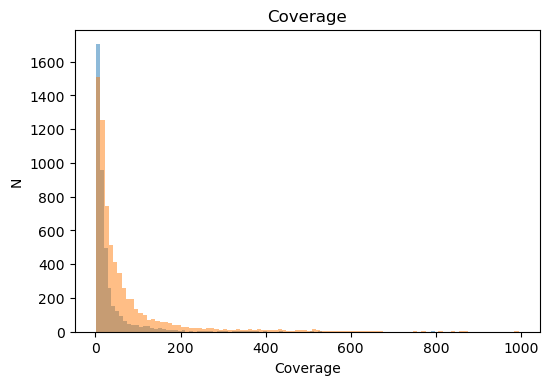

In [126]:
## Coverage
print('Coverage_Kmer:',Org_df.Coverage_Kmer.quantile([.1, .5, .9, .99]).round().to_dict())
print('Coverage_base:',Org_df.Coverage_base.quantile([.1, .5, .9, .99]).round().to_dict())
plt.figure(figsize=(6, 4), dpi=100)
plt.hist(Org_df[Org_df.Coverage_Kmer<1000].Coverage_Kmer, bins=100, alpha=0.5, label='Kmer')
plt.hist(Org_df[Org_df.Coverage_base<1000].Coverage_base, bins=100, alpha=0.5, label='Bases')
plt.title("Coverage"); plt.xlabel('Coverage'); plt.ylabel('N'); plt.show()

74 pt with repeat pattern


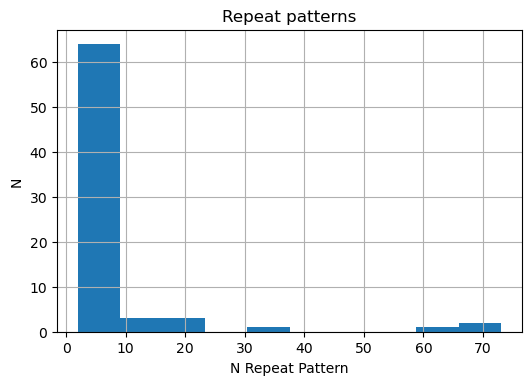

In [127]:
## Repeat Patterns
print((Org_df.NRepeat_Pattern.isna()==False).sum(),'pt with repeat pattern')
plt.figure(figsize=(6, 4), dpi=100)
Org_df.NRepeat_Pattern.hist();
plt.title("Repeat patterns"); plt.xlabel('N Repeat Pattern'); plt.ylabel('N'); plt.show()

In [128]:
## Error types
print('N plastome errors:',Org_df.error_pt.notnull().sum(), ', N rDNA errors:',Org_df.error_nr.notnull().sum(),end='\n\n')
print(Org_df.groupby('error_pt').size().sort_values(ascending=False),end='\n\n')
print(Org_df.groupby('error_nr').size().sort_values(ascending=False))

N plastome errors: 522 , N rDNA errors: 541

error_pt
TypeError: 'NoneType' object is not subscriptable                                             169
Too few seed reads found!                                                                     142
TypeError: unsupported operand type(s)                                                         80
No embplant_pt seed reads found!                                                               40
ERROR: Error in SPAdes                                                                         38
ERROR: No valid assembly graph found!                                                          18
INFO: Disentangling timeout                                                                    15
AssertionError                                                                                  9
"No available " + database_name + " information found                                           5
Disentangling failed: 'Unable to generate result with single cop

In [129]:
## Missing data
print(Org_df.isna().sum().to_dict())

{'idPaftol': 0, 'idSequencing': 0, 'Sample_Name': 0, 'Project': 0, 'order': 38, 'family': 38, 'genus': 0, 'sci_name': 0, 'SumContigLength': 1058, 'log_pt': 0, 'log_nr': 0, 'pt_recovered': 0, 'Nseq_pt': 665, 'Sum_len_pt': 665, 'Nanybase_pt': 665, 'nr_recovered': 0, 'Nseq_nr': 687, 'Sum_len_nr': 687, 'Nanybase_nr': 687, 'Completed_Reads': 140, 'Completed_Extending': 140, 'Completed_Assembly': 140, 'Completed_Slimming': 140, 'Completed_Output': 140, 'Warning_Look': 140, 'Warning_Multi_Structure': 140, 'Warning_Self_Loop': 140, 'Info_Large_Repeats': 140, 'Info_Disentangling_Failed': 140, 'Assembly': 681, 'Coverage_Kmer': 3220, 'Coverage_base': 681, 'maxK': 681, 'NRepeat_Pattern': 7466, 'NPath': 7508, 'Redo_FastPlast': 0, 'error_pt': 7018, 'error_nr': 6999}


In [130]:
## Outliers
print((Org_df.Sum_len_pt>200000).sum(),'pt outliers > 200kb')
Org_df[Org_df.Sum_len_pt>200000][['order','family','sci_name','Sum_len_pt','Nseq_pt','Assembly']]

7 pt outliers > 200kb


,order,family,sci_name,Sum_len_pt,Nseq_pt,Assembly
4612,Poales,Poaceae,Pseudechinolaena polystachya,208807.0,1.0,circular genome
4657,Cucurbitales,Cucurbitaceae,Corallocarpus welwitschii,200557.0,17.0,scaffold
5277,Sapindales,Anacardiaceae,Haplorhus peruviana,232764.0,4.0,scaffold
5353,Sapindales,Rutaceae,Crowea exalata,214937.0,5.0,scaffold
5902,Ericales,Primulaceae,Deherainia matudae,371436.0,13.0,scaffold
5982,Ericales,Ericaceae,Satyria warszewiczii,538490.0,12.0,scaffold
7155,Boraginales,Boraginaceae,Chionocharis hookeri,200023.0,5.0,scaffold


309 species, 288 genera, 82 families, {1.0: 339}


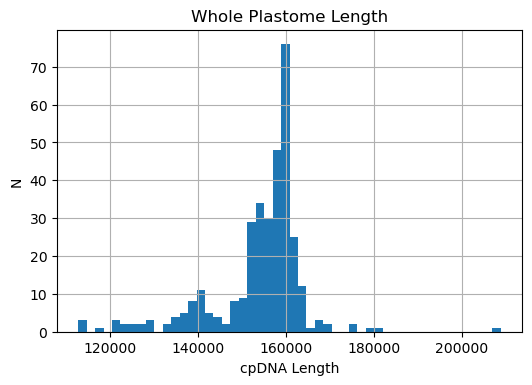

In [131]:
## Complete plastomes
whole_pt=Org_df[(Org_df.Assembly.isin(['circular genome','circular genome with gaps']) & (Org_df.Sum_len_pt>80000))]
print(whole_pt.sci_name.nunique(),'species,',whole_pt.genus.nunique(),'genera,',
      whole_pt.family.nunique(),'families,',whole_pt.groupby('Nseq_pt').size().to_dict())
plt.figure(figsize=(6, 4), dpi=100)
whole_pt.Sum_len_pt.hist(bins=50);
plt.title("Whole Plastome Length"); plt.xlabel('cpDNA Length'); plt.ylabel('N'); plt.show()

In [132]:
print('close to completion pt(>=1 seq > 100000):',
      Org_df[(Org_df.Nseq_pt>=1)&(Org_df.Sum_len_pt>100000)&(Org_df.Sample_Name.isin(whole_pt.Sample_Name)==False)].shape[0])

close to completion pt(>=1 seq > 100000): 1064


Sum_len_pt: {0.1: 3191.0, 0.5: 27090.0, 0.9: 132718.0}


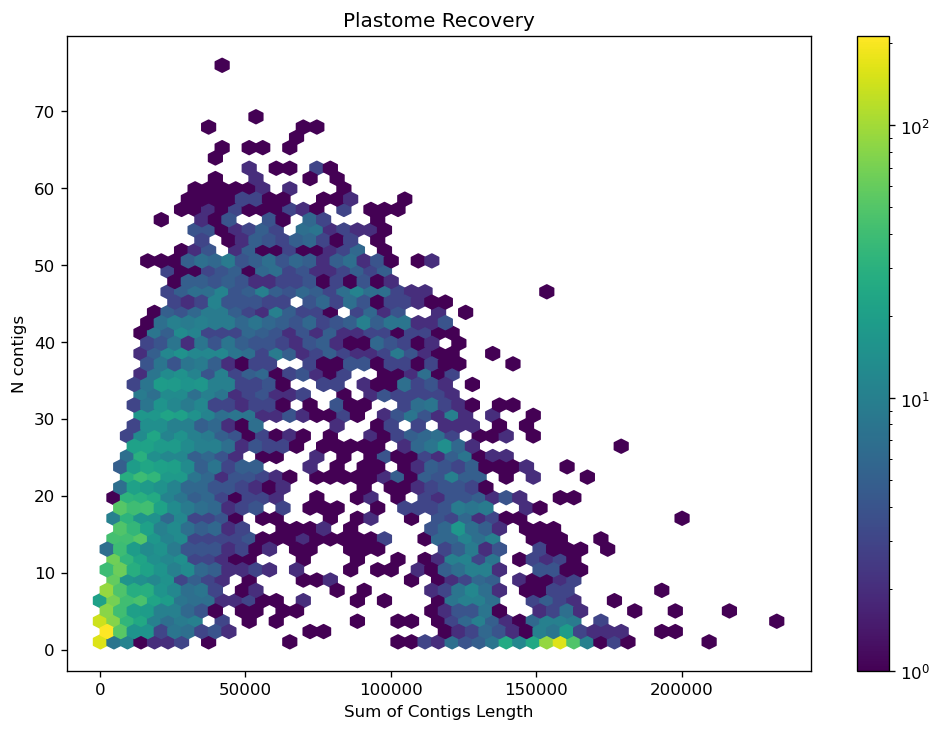

In [133]:
print('Sum_len_pt:',Org_df.Sum_len_pt.quantile([.1, .5, .9]).round().to_dict())
plt.figure(figsize=(10, 7), dpi=120)
plt.hexbin(x=Org_df[Org_df.Sum_len_pt<300000].Sum_len_pt, y=Org_df[Org_df.Sum_len_pt<300000].Nseq_pt, 
           gridsize=50, bins='log', mincnt=1); plt.colorbar()
plt.title("Plastome Recovery"); plt.xlabel('Sum of Contigs Length'); plt.ylabel('N contigs'); plt.show()

len_nr: {0.1: 1544.0, 0.5: 6414.0, 0.9: 9288.0}
whole rDNA (1 seq > 4000): 3309


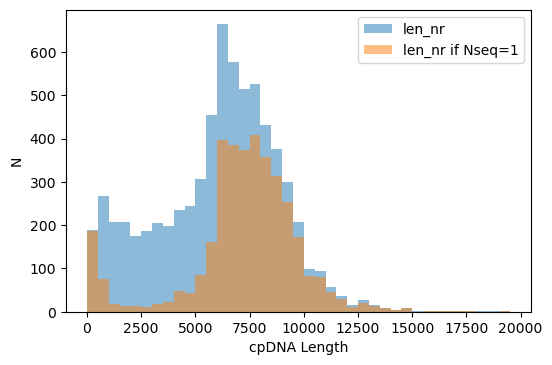

In [134]:
print('len_nr:',Org_df.Sum_len_nr.quantile([.1, .5, .9]).round().to_dict())
print('whole rDNA (1 seq > 4000):',Org_df[(Org_df.Nseq_nr==1) & (Org_df.Sum_len_nr>4000)].shape[0])
plt.figure(figsize=(6, 4), dpi=100)
plt.hist(Org_df.Sum_len_nr, bins=range(0,20000,500), alpha=0.5, label='len_nr')
plt.hist(Org_df[Org_df.Nseq_nr==1].Sum_len_nr, bins=range(0,20000,500), alpha=0.5, label='len_nr if Nseq=1')
plt.legend(loc='upper right'); plt.xlabel('cpDNA Length'); plt.ylabel('N'); plt.show()

Sum_len_pt: {0.1: 1544.0, 0.5: 6414.0, 0.9: 9288.0}


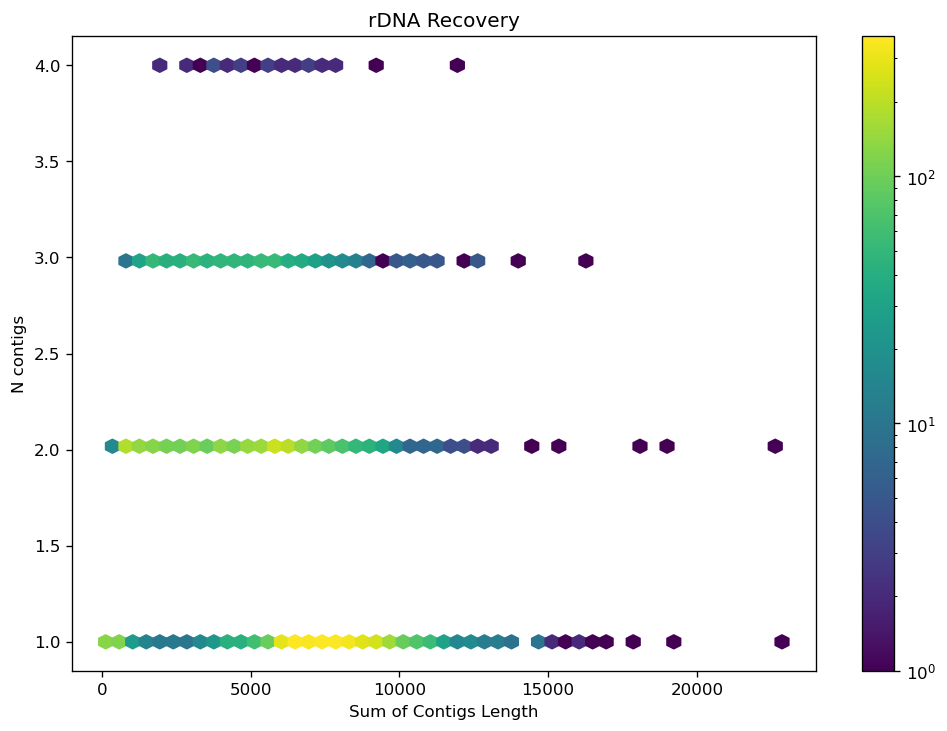

In [135]:
print('Sum_len_pt:',Org_df.Sum_len_nr.quantile([.1, .5, .9]).round().to_dict())
plt.figure(figsize=(10, 7), dpi=120)
plt.hexbin(x=Org_df.Sum_len_nr, y=Org_df.Nseq_nr, 
           gridsize=50, bins='log', mincnt=1); plt.colorbar()
plt.title("rDNA Recovery"); plt.xlabel('Sum of Contigs Length'); plt.ylabel('N contigs'); plt.show()

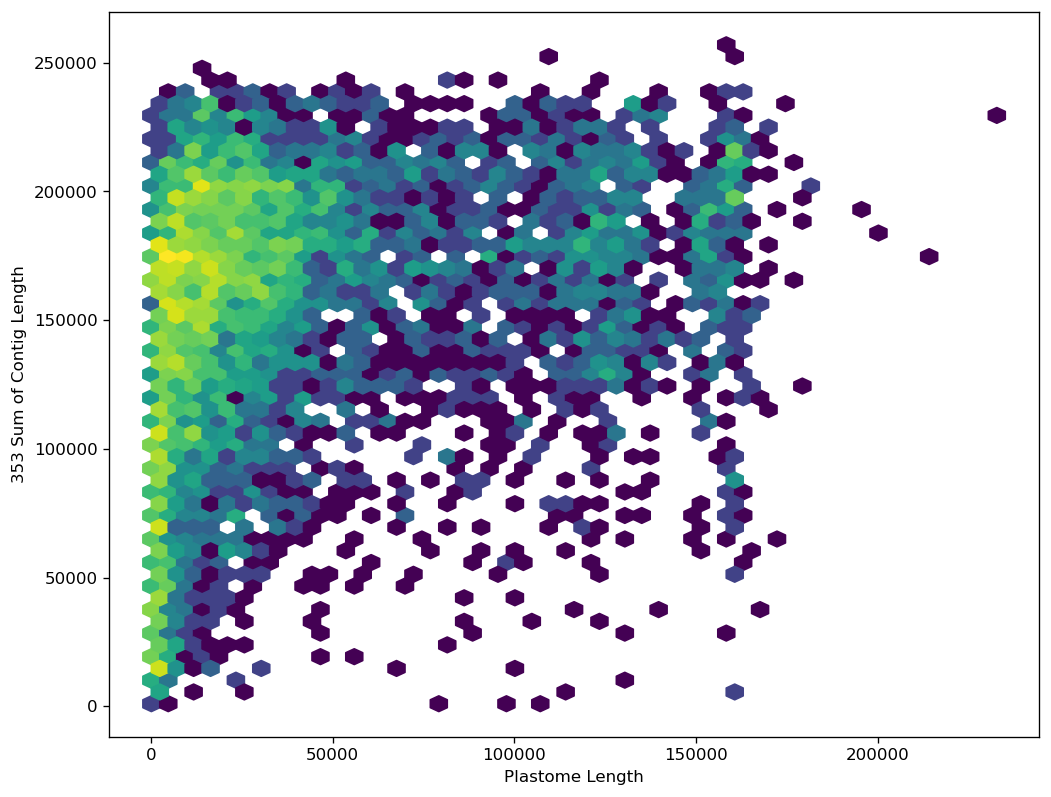

In [136]:
plt.figure(figsize=(10, 8), dpi=120)
plt.hexbin(x=Org_df.Sum_len_pt, y=Org_df.SumContigLength, gridsize=50, bins='log', mincnt=1); 
plt.xlabel('Plastome Length'); plt.ylabel('353 Sum of Contig Length'); plt.show()

In [137]:
os.system('jupyter nbconvert --to html --output ' +
          working_dir + project + '_GetOrg_Recovery_Notebook C:/Data/PAFTOL/GetOrganelles/GetOrg_Recovery.ipynb')

0

## Validation

In [138]:
# ## List for validation
# print(getorg_df.shape)
# getorg_df[['Sample_Name','Family','Genus','Species']].to_csv('../../Barcoding_Validation/PAFTOL/PAFTOL_GetOrg_Samples.csv',
#                                                              header=None,index=False)
# getorg_df.to_csv('../../Barcoding_Validation/PAFTOL/Samples_PAFTOL_GetOrg.csv',index=False)
# getorg_df[:2]

In [139]:
# validation=pd.read_excel('../../Barcoding_Validation/'+working_dir+'/'+working_dir+'_Barcoding_Validation_TablesN.xlsx',
#                          sheet_name='Validation_Results')
# print(validation.shape)
# validation[:2]

In [140]:
# v2=pd.merge(getorg_df[['Sample_Name','len_pt','len_nr']].fillna(0),validation[['Sample','NV_fam']],
#            how='inner',left_on='Sample_Name',right_on='Sample')
# v2=v2[v2.len_pt<250000]
# v2['len_full']=v2.len_pt+v2.len_nr
# v2[['NV_fam','len_full']].boxplot(by='NV_fam',patch_artist = True);

In [141]:
# v2['pt_50']=v2.len_pt>80000
# v2['nr_50']=v2.len_nr>4000
# v2['min50']=v2.pt_50.astype(int)+v2.nr_50.astype(int)
# v2[['NV_fam','min50']].boxplot(by='min50',patch_artist = True);